# memOptix
**Purpose**

The aim of this notebook is to run through a Windows memory dump in a structured manner to detect suspicious or malicious indicators and behaviours.

Please note that this notebook was created based on the output generated from CrowdStrike's Supermem python script (https://github.com/CrowdStrike/SuperMem). SuperMem triage mode 2 or 3 should be run against the memory dump prior to running this notebook. You may decide to run volatility interactively if you wish to do so. Supermem dumps various other artefacts from the memory dump which can assist with investigations.

Following Open Source projects are used within this notebook:  
https://github.com/microsoft/msticpy  
https://github.com/volatilityfoundation/volatility3  
https://github.com/CrowdStrike/SuperMem

Author : Janantha Marasinghe

### <a href=#prerequisites>Pre-requisites</a>
Let's first install the python packages that are pre-requisites for this script. Please note that msticpy now only supports <b>python 3.8 or above</b>. 

In [ ]:
%pip install msticpy\[azure] seaborn jellyfish pandas argparse colorama selenium pillow

### Importing all the libraries required
We are not using VT in this notebook. You will get an error complaining about import failure for VT. Please ignore it. Alternatively you may proceed installing installing the VT extra for msticpy as instructed.

In [1]:
from pickle import FALSE
import jellyfish
import pandas as pd
import argparse
import sys
import re
import os
from colorama import init, Fore, Back, Style


# Initialise the mstic
import msticpy as mp
from msticpy.transform.iocextract import IoCExtract
#from msticpy import init_notebook
mp.init_notebook(verbosity=0)



#This will ensure the pandas output results do not get truncated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


msticpy.common.exceptions.MsticpyImportExtraError('Cannot use this feature without vt-py, vt-graph-api and',
                                                  'nest_asyncio packages installed.')

### Setting up the MSTICPY CTI providers for IOC lookups

In [2]:
intel = mp.TILookup()


### <a href=#generatecsvs>Generate the relevant CSVs in preparation</a>
<b>This is only required if you do not have the required CSVs</b> to run the notebook. Please note that this stage can take a while to complete.You will see a * within the square brackets next to the below function as long as it is processing the step. Do not proceed until you see a number within the square brackets.

In [ ]:
mem_inpath = "PATH_TO_YOUR_MEMORY_IMAGE"
mem_outpath = "PATH_TO_YOUR_CSV_OUTPUT"
volplug_lst = ["windows.pslist.PsList","windows.cmdline.CmdLine"," windows.netscan.NetScan","windows.callbacks.Callbacks","windows.driverscan.DriverScan"," windows.dlllist.DllList","windows.svcscan.SvcScan","windows.handles.Handles","windows.malfind.Malfind","windows.ssdt.SSDT"]

for plugin in volplug_lst:
    vol_execute = "bash -c 'vol -f " + mem_inpath + " -r csv " + plugin + " > " + mem_outpath + plugin + ".csv'"
    os.system(vol_execute)



### YOU MAY CHOOSE TO "RUN ALL BELOW" CELL ACTION FROM THIS POINT 

### <a href=#csvfolderpath>Setting up variables for the notebook</a> 
Please paste the folder path containing the CSV output from Volatility.

In [3]:
process_input = "PATH_TO_YOUR_CSV_OUTPUT"

### <a href=#csv2df>Load CSV data into Dataframes</a>
Load the following CSV files into a dataframes for processing. Analyst tasks are run against the pandas dataframes. Please ensure you go <a href="#csvfolderpath">here</a> and put the path to your CSVs before running the following code block.

In [4]:
dfprocs = pd.read_csv(process_input + '/windows.pslist.PsList.csv')
dfcmdline = pd.read_csv(process_input +'/windows.cmdline.CmdLine.csv')
dfnetscan = pd.read_csv(process_input +'/windows.netscan.NetScan.csv')
dfcallbacks = pd.read_csv(process_input +'/windows.callbacks.Callbacks.csv')
dfdriverscan = pd.read_csv(process_input +'/windows.driverscan.DriverScan.csv')
dfdlllist = pd.read_csv(process_input +'/windows.dlllist.DllList.csv')
dfsvcscan = pd.read_csv(process_input +'/windows.svcscan.SvcScan.csv')
dfhandles = pd.read_csv(process_input +'/windows.handles.Handles.csv')
dfmalfind = pd.read_csv(process_input +'/windows.malfind.Malfind.csv')
dfssdt = pd.read_csv(process_input +'/windows.ssdt.SSDT.csv')   

### <a href=#ParentProcMap>Adding Parent Process Name to the process tree data frame</a>
Adding a parent process name "ParentName" column to make it more human friendly.Please note that certain processes may not contain a parent process name. This is due to early exit of such parent processes.

In [5]:
dfppidtxt = dfprocs[['PID', 'ImageFileName']].drop_duplicates()
dfppidtxt.columns = ['PPID', 'ParentName']
dfprocs = dfprocs.merge(dfppidtxt, on='PPID', how='left')

<a href=#typesquat>Widely Targeted Windows processes</a>
This array contains commonly targeted Windows processes that are often used by type squatted by threat actors.

In [6]:
actprocsbaselst =["svchost.exe","wininit.exe","lsass.exe","explorer.exe","iexplore.exe","powershell.exe","cmd.exe","services.exe","csrss.exe","smss.exe","silhost.exe","taskhost.exe"]

<a href=#singleprocs>Windows processes that should only have a single instance</a>
This array contains a list of processes which should only have a single instance of itself during normal operation of Windows.

In [43]:
singleprocs = ["system","wininit.exe","lsass.exe","lsm.exe","services.exe","lsaiso.exe"]

### <a href=#pr1>PR1 - Identifying processes that should not have more than one instance</a>
Checks to see if there are more than one process for processes listed in singleprocs array.

In [44]:
for procs in singleprocs:
    p_count = dfprocs[dfprocs.ImageFileName.str.lower() == procs].shape[0]
    if p_count == 1:
        print(Fore.GREEN + "[✓]No multiple instance(s) of " + procs + " found")
    elif p_count > 1:
        print(Fore.RED + "[!]Multiple instance(s) of " + procs + " found!")
        print(dfprocs[dfprocs.ImageFileName.str.lower() == procs][['ImageFileName','PID','PPID','ParentName']].to_string(index = False))

[✓]No multiple instance(s) of system found
[✓]No multiple instance(s) of wininit.exe found
[✓]No multiple instance(s) of lsass.exe found
[✓]No multiple instance(s) of services.exe found


### <a href=#pr2>PR2 - Identifying suspicious parent-child process lineage</a>

Parent processes of services.exe, iexplore.exe, svchost.exe, cmd.exe and powershell.exe are usually known. This search tries to identify when they are spawned from unusual parent processes.

In [10]:
sus_services = dfprocs[(dfprocs.ImageFileName.str.lower() == "services.exe") & (dfprocs.ParentName.str.lower() != "wininit.exe")][['ImageFileName','PID','PPID','ParentName']]
if(sus_services.empty):
    print(Fore.GREEN + "[✓]No suspicious instances of services.exe were found")
else:
    print(Fore.RED + "[!]Suspicious services.exe process(s) found")
    print(sus_services.to_string(index = False))
    
sus_iexplorer = dfprocs[(dfprocs.ImageFileName.str.lower() == "iexplore.exe") & (dfprocs.ParentName.str.lower() != "explorer.exe")][['ImageFileName','PID','PPID','ParentName']]
if (sus_iexplorer.empty): 
    print(Fore.GREEN + "[✓]No suspicious instances of iexplore.exe were found")
else:
    print(Fore.RED + "[!]iexplore.exe spawned from a suspicious parent")
    print(sus_iexplorer.to_string(index = False))
sus_svchost= dfprocs[(dfprocs.ImageFileName.str.lower() == "svchost.exe") & (dfprocs.ParentName.str.lower() != "services.exe")][['ImageFileName','PID','PPID','ParentName']]
if (sus_svchost.empty):
    print(Fore.GREEN + "[✓]No suspicious instances of svchost.exe were found")
else:
    print(Fore.RED + "[!]svchost.exe spawned from a suspicious parent")
    print(sus_svchost.to_string(index = False))
sus_cli = dfprocs[((dfprocs.ImageFileName.str.lower() == "cmd.exe") | (dfprocs.ImageFileName.str.lower() == "powershell.exe")) & (dfprocs.ParentName.str.lower() != "explorer.exe")][['ImageFileName','PID','PPID','ParentName']]
if (sus_cli.empty):
    print(Fore.GREEN + "[✓]No suspicious instances of cmd.exe or powershell.exe were found")
else:
    print(Fore.RED + "[!]cmd.exe or powershell.exe spawned by an unusual parent!")
    print(sus_cli.to_string(index = False))

[✓]No suspicious instances of services.exe were found
[✓]No suspicious instances of iexplore.exe were found
[✓]No suspicious instances of svchost.exe were found
[✓]No suspicious instances of cmd.exe or powershell.exe were found


### <a href=#pr3>PR3 - Identifying suspicious processes using Damerau-Levenshtein distance</a>
This compares the Damerau-Levenshtein value between a legitimate process (in actprocsbaselst array) and existing processes available in the memory image. The Damerau–Levenshtein distance works on the distance between two words, which is the least number of operations needed to change one word into another. Currently we are looking at 2 or fewer changes. Please note that the output of this task needs to be further optimised.

In [11]:
#http://detect-respond.blogspot.com/2016/11/hunting-for-malware-critical-process.html
#Following adds live processes to a list and deduplicates it
liveprocs=[]
levratedprocs = []
for susproc in dfprocs["ImageFileName"].str.lower():
    if susproc not in liveprocs:
        liveprocs.append(susproc)

for x,y in [(x,y) for x in liveprocs for y in actprocsbaselst]:
    levdistance = (jellyfish.damerau_levenshtein_distance(x,y))
    if 0 < levdistance <= 2:
        #print(x,y,levdistance)
        levratedprocs.append([x, y,levdistance])

#Convert list to a dataframe
dflevprocs = pd.DataFrame(levratedprocs, columns = ['LiveProcess', 'BaseProcess','Damerau–Levenshtein distance'])

#Reduce false positives by removing known process pairs
procfpredux = dflevprocs[((dflevprocs.LiveProcess.str.lower().isin(['lsass.exe', 'csrss.exe','smss.exe','dllhost.exe','explorer.exe','svchost.exe','sihost.exe'])) & (dflevprocs.BaseProcess.str.lower().isin(['lsass.exe', 'csrss.exe','smss.exe','silhost.exe','iexplore.exe','svchost.exe']))) == False]

if (procfpredux.empty):
    print(Fore.GREEN + "[✓]No processes were identified for Damerau-Levenshtein analysis")
else:
    print(Fore.RED + "[!]Suspicious processes were identified")
    display(procfpredux)

[!]Suspicious processes were identified


,LiveProcess,BaseProcess,Damerau–Levenshtein distance
9,taskhostw.exe,taskhost.exe,1


### <a href=#pr4>PR4 - Identifying svchost.exe or rundll32.exe without any command line arguments</a>
svchost.exe or rundll32.exe should always command line arguments. If it doesn't, then it is highly suspicious. rundll32.exe without command line arguments is one of the behaviours associated with Cobalt Strike. svchost.exe without parameters is highly abnormal and often used by an adversary to blend in.

In [12]:
nocmdargs_svc = (dfcmdline[dfcmdline["Args"].str.match(r'^(.*(svchost|rundll32)\.exe)$')])[['PID','Process','Args']]
if (nocmdargs_svc.empty):
    print(Fore.GREEN + "[✓]No svchost.exe or rundll32.exe instance(s) identified without commandline arguments")
else:
    print(Fore.RED + "[!]svchost.exe or rundll32.exe without command line was detected!")
    print(nocmdargs_svc.to_string(index = False))
    

[✓]No svchost.exe or rundll32.exe instance(s) identified without commandline arguments


### <a href=#pr5>PR5 - Processes spawned from suspicious folder locations</a>
Processes spawned from directories such as Desktop, Public, Documents, Downloads, Temp, ProgramData (root) are often suspicious.

In [13]:
sus_procspawn = (dfcmdline[dfcmdline["Args"].str.match(r'.*[A-Za-z]:\\.*(Desktop|Public|Documents|Downloads|Temp|ProgramData)\\\w+\.exe.*')])[['PID','Process','Args']]
if (sus_procspawn.empty):
    print(Fore.GREEN + "[✓]No processes were found to have been spawned from suspicious locations")
else:
    print(Fore.RED + "[!]Suspicious processes identified!")
    print(sus_procspawn.to_string(index = False))

[!]Suspicious processes identified!
 PID        Process                                                                      Args
  32   PSclient.exe "C:\Users\Public\PSclient.exe" -autorestart -relayserver 13.54.35.87:5555
6580 winpmem_mini_x             "C:\Users\dadmin\Desktop\winpmem_mini_x64_rc2.exe" memory.raw


### <a href=#pr6>PR6 - Process network graph</a>
Graph visualisation can assist in identifying suspicious processes using parent-child relationships. Use the interactive options within the data graph to zoom in/out.

In [15]:
dfprocs.mp_plot.network(
    source_col="ImageFileName",
    target_col="ParentName",
    source_attrs=["PID", "ParentName","CreateTime","ExitTime"],
    edge_attrs=["CreateTime"],
)



Loading BokehJS ...

Figure(id='1283', ...)

### <a href=#pr7>PR7 - Anomalous Process Detection using time duration</a>
This analyst task involves visually observing the life timeline, a process at the time the memory dump was taken. Processes which have a shorter lifespan are suspicious and may require further analysis. In addition, you may also detect malicious or suspicious process behaviour just by visually observing the spawn time as time goes by. First we create a new dataframe containing processes that has exit timestamps. This way we are reducing the noise. Then we create a "Timeline Duration" visualisation using the msticpy library.

In [16]:
dfprocs_exit = dfprocs[dfprocs.ExitTime.notnull()]
mp.vis.timeline_duration.display_timeline_duration(dfprocs_exit, group_by="ImageFileName", time_column="CreateTime", end_time_column="ExitTime")

Loading BokehJS ...

Column(id='1665', ...)

### <a href=#PR8>PR8 - Suspicious commandline arguments</a>
Checks to identify suspicious commandline arguments which are often observed in intrusions.

In [17]:
sus_cmdargs = dfcmdline[dfcmdline["Args"].str.match(r".*(nop|NoLogo|noni|invoke-expression|WebClient|EncodedCommand|nop|reflection\.assembly|-enc|IO\.Compression|DownloadString|System\.Net\.WebClient|Hidden|iex|FromBase64|powershell\.cpl|base64|MemoryStream)|COMSPEC|IABz|SQBFAFgA|aWV4I|aQBlAHgA|SUVYI|(whoami|certutil|bitsadmin|mshta|StartW|MiniDump|comsvcs\.dll).*", case=False) == True][['PID','Process','Args']]
if (sus_cmdargs.empty):
    print(Fore.GREEN + "[✓]No suspicious commandline arguments detected")
else:
    print(Fore.RED + "[!]Suspicious commandline arguments detected!")
    print(sus_cmdargs.to_string(index = False))

[✓]No suspicious commandline arguments detected


In [19]:
ioc_extractor = IoCExtract()
ioc_df = ioc_extractor.extract(data=dfcmdline, columns=['Args'])
if len(ioc_df):
    display("IoC patterns found in process tree")
    display(ioc_df)

'IoC patterns found in process tree'

,IoCType,Observable,SourceIndex,Input
0,ipv4,13.54.35.87,104,"""C:\Users\Public\PSclient.exe"" -autorestart -relayserver 13.54.35.87:5555"


### <a href=#PR9>PR9 - rundll32.exe spawned by a suspicious parent process</a>
Attempting to detect rundll32.exe spawning from suspicious parent processes.

In [20]:
susdllloc = dfprocs[((dfprocs.ImageFileName.str.lower() == "rundll32.exe")) & (dfprocs.ParentName.str.lower().isin(['winword.exe', 'excel.exe','msaccess.exe','lsass.exe','taskeng.exe','winlogon.exe','schtask.exe','regsvr32.exe','wmiprvse.exe','wsmprovhost.exe']))][['ImageFileName','PID','PPID','ParentName']]
if (susdllloc.empty):
    print(Fore.GREEN + "[✓]No suspicious rundll32 parent detected")
else:
    print(Fore.RED + "[!]Suspicious rundll32.exe parent detected!")
    print(susdllloc.to_string(index = False))

[✓]No suspicious rundll32 parent detected


### <a href=#NT1>NT 1 - Visual network interactions</a>
The following matrix plot shows confirmed intersects between source and destination IPs with descending order of connections.

In [21]:
from msticpy.vis.matrix_plot import plot_matrix
plot_matrix(data=dfnetscan, x="ForeignAddr", y="LocalAddr", title="IP interactions", sort="dsc" ,  intersect=True)

Loading BokehJS ...

Figure(id='1916', ...)

### <a href=#NT2>NT2 - No of external network communications per public IP</a>
The following bar chart shows external network connections with the number of occurrences within the memory image.

<AxesSubplot:>

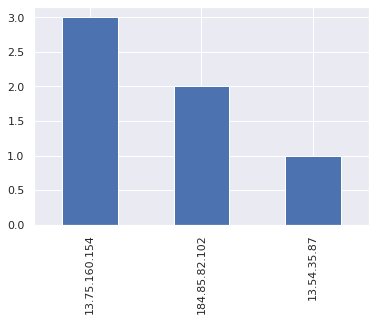

In [22]:
dfnetscan[(dfnetscan["ForeignAddr"].str.match(r'(?!^0\.)(?!^10\.)(?!^100\.6[4-9]\.)(?!^100\.[7-9]\d\.)(?!^100\.1[0-1]\d\.)(?!^100\.12[0-7]\.)(?!^127\.)(?!^169\.254\.)(?!^172\.1[6-9]\.)(?!^172\.2[0-9]\.)(?!^172\.3[0-1]\.)(?!^192\.0\.0\.)(?!^192\.0\.2\.)(?!^192\.88\.99\.)(?!^192\.168\.)(?!^198\.1[8-9]\.)(?!^198\.51\.100\.)(?!^203.0\.113\.)(?!^22[4-9]\.)(?!^23[0-9]\.)(?!^24[0-9]\.)(?!^25[0-5]\.)(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5]))$') == True)]["ForeignAddr"].value_counts().plot(kind='bar')

### <a href=#NT3>NT3 - Intelligence matches for external network connections</a>
Closed network connections that communicate with public IPs can usually contain interesting IP information. This may need to be further restricted to non-standard ports as port 80/443 traffic can be noisy.

In [23]:
ext_netclose = dfnetscan[(dfnetscan["ForeignAddr"].str.match(r'(?!^0\.)(?!^10\.)(?!^100\.6[4-9]\.)(?!^100\.[7-9]\d\.)(?!^100\.1[0-1]\d\.)(?!^100\.12[0-7]\.)(?!^127\.)(?!^169\.254\.)(?!^172\.1[6-9]\.)(?!^172\.2[0-9]\.)(?!^172\.3[0-1]\.)(?!^192\.0\.0\.)(?!^192\.0\.2\.)(?!^192\.88\.99\.)(?!^192\.168\.)(?!^198\.1[8-9]\.)(?!^198\.51\.100\.)(?!^203.0\.113\.)(?!^22[4-9]\.)(?!^23[0-9]\.)(?!^24[0-9]\.)(?!^25[0-5]\.)(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5]))$') == True)][["ForeignAddr","ForeignPort","Owner"]]
if (ext_netclose.empty):
    print(Fore.GREEN + "[✓]No closed external connections were detected")
else:
    print(Fore.RED + "[!]Terminated external network connections detected")
    ext_netclose.to_string(index = False)
    print("\n")
    print("Positive Threat Intelligence Enrichment on the IPs")
    ext_netclose.drop_duplicates(subset ="ForeignAddr", keep = False, inplace = True)
    resraw_intel = intel.lookup_iocs(data=ext_netclose, obs_col="ForeignAddr")
    res_intel = resraw_intel[resraw_intel["Result"]==True]
    
    #Dropping columns that are not required 
    res_intel_cut = res_intel.drop(['QuerySubtype','RawResult','Result'], axis=1)
    display(res_intel_cut)


[!]Terminated external network connections detected


Positive Threat Intelligence Enrichment on the IPs


Observables processed:   0%|          | 0/2 [00:00<?, ?obs/s]

,Ioc,IocType,SanitizedValue,Provider,Severity,Details,Reference,Status
0,13.54.35.87,ipv4,13.54.35.87,OTX,information,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list', 'http_scans']}",https://otx.alienvault.com/api/v1/indicators/IPv4/13.54.35.87/general,0


### <a href=#NT4>NT4 - Suspicious web connections that are not related to browsers</a>
Web browsers usually communicate over port 80,443 or 8080. This shows processors which are not common browsers that communicate over those ports.

In [40]:
sus_http = dfnetscan[(dfnetscan["ForeignPort"] == 8080) | (dfnetscan["ForeignPort"] == 80) | (dfnetscan["ForeignPort"] == 443) & ((dfnetscan.Owner.str.lower() != "msmpeng.exe") & (dfnetscan.Owner.str.lower() != "chrome.exe") & (dfnetscan.Owner.str.lower() != "msedge.exe") & (dfnetscan.Owner.str.lower() != "firefox.exe") & (dfnetscan.Owner.str.lower() != "iexplorer.exe"))][["ForeignAddr","ForeignPort","Owner"]]
if (sus_http.empty):
    print(Fore.GREEN + "[✓]No suspicious web connections were detected")
else:
    print(Fore.RED + "[!]None browser based web connections were detected")
    print(sus_http.to_string(index = False))
    print("\n")
    print("Positive Threat Intelligence Enrichment on the IPs")
    resraw_intel2 = intel.lookup_iocs(data=sus_http, obs_col="ForeignAddr", providers=["GreyNoise","OTX"])
    res_intel2 = resraw_intel2[resraw_intel2["Result"]==True]
    
    #Dropping columns that are not required 
    res_intel2_cut = res_intel2.drop(['QuerySubtype','RawResult','Result'], axis=1)
    display(res_intel2_cut)

[!]None browser based web connections were detected
  ForeignAddr  ForeignPort       Owner
184.85.82.102           80 svchost.exe
184.85.82.102           80 svchost.exe


Positive Threat Intelligence Enrichment on the IPs


Observables processed:   0%|          | 0/4 [00:00<?, ?obs/s]

,Ioc,IocType,SanitizedValue,Provider,Severity,Details,Reference,Status
0,184.85.82.102,ipv4,184.85.82.102,GreyNoise,information,"{'Classification': 'benign', 'Name': 'Akamai Technologies', 'Last Seen': '2022-08-21', 'Message': 'Success', 'Noise': False, 'RIOT': True}",https://api.greynoise.io/v3/community/184.85.82.102,0
1,184.85.82.102,ipv4,184.85.82.102,GreyNoise,information,"{'Classification': 'benign', 'Name': 'Akamai Technologies', 'Last Seen': '2022-08-21', 'Message': 'Success', 'Noise': False, 'RIOT': True}",https://api.greynoise.io/v3/community/184.85.82.102,0
0,184.85.82.102,ipv4,184.85.82.102,OTX,information,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list', 'http_scans']}",https://otx.alienvault.com/api/v1/indicators/IPv4/184.85.82.102/general,0
1,184.85.82.102,ipv4,184.85.82.102,OTX,information,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list', 'http_scans']}",https://otx.alienvault.com/api/v1/indicators/IPv4/184.85.82.102/general,0


### <a href=#NT5>NT5 - IP address in commandline arguments</a>
Detect explicit use of IP addresses in command line arguments.

In [25]:
ip_cmdline = dfcmdline[dfcmdline["Args"].str.match(r'.*(?!^0\.)(?!^10\.)(?!^100\.6[4-9]\.)(?!^100\.[7-9]\d\.)(?!^100\.1[0-1]\d\.)(?!^100\.12[0-7]\.)(?!^127\.)(?!^169\.254\.)(?!^172\.1[6-9]\.)(?!^172\.2[0-9]\.)(?!^172\.3[0-1]\.)(?!^192\.0\.0\.)(?!^192\.0\.2\.)(?!^192\.88\.99\.)(?!^192\.168\.)(?!^198\.1[8-9]\.)(?!^198\.51\.100\.)(?!^203.0\.113\.)(?!^22[4-9]\.)(?!^23[0-9]\.)(?!^24[0-9]\.)(?!^25[0-5]\.)(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])).*') == True][['PID','Process','Args']]
if (ip_cmdline.empty):
    print(Fore.GREEN + "[✓]No IPs in commandline arguments detected")
else:
    print(Fore.RED + "[!]IP address in commandline arguments detected!")
    print(ip_cmdline.to_string(index = False))

[!]IP address in commandline arguments detected!
 PID      Process                                                                      Args
  32 PSclient.exe "C:\Users\Public\PSclient.exe" -autorestart -relayserver 13.54.35.87:5555


### <a href=#st1>ST1 - Check for malicious Kernel callbacks (indicator of rootkit activity)</a>
Malicious kernel callbacks often don't include the name of the kernel module. This results it being named as UNKNOWN. If you see such an entry, then you should use the driverscan plugin to check files that are surrounding the memory region of the malicious kernel callback.

In [26]:
rootkit_indicator = dfcallbacks[(dfcallbacks.Module.str.lower() == "unknown")][["Type","Callback","Module","Detail"]]
if (rootkit_indicator.empty):
    print(Fore.GREEN + "[✓]No suspicious callbacks detected")
else:
    print(Fore.RED + "[!]Suspicious callbacks identified (behaviour of a rootkit)!")
    print(rootkit_indicator.to_string(index = False))

[✓]No suspicious callbacks detected


### <a href=#st2>ST2 - Suspicious SSDT hooking (indicator of rootkit activity)</a>
Suspicious SSDT hooking by kernel modules that are not reside in the usual directory paths.

In [27]:
sus_kernelhook = dfssdt[(dfssdt["Module"].str.match(r".*(ntoskrnl1|win32k).*",case=False) == False)][["Address","Module","Symbol"]]
if (sus_kernelhook.empty):
    print(Fore.GREEN + "[✓]No suspicious SSDT hooking detected")
else:
    print(Fore.RED + "[!]Suspicious SSDT hooking detected!")
    print(sus_kernelhook.to_string(index = False))

[✓]No suspicious SSDT hooking detected


### <a href=#ST3>ST3 - Check for drivers with the base address wiped out (indicator of rootkit activity)</a>
Malware can wipe the base address of its kernel driver to hide itself. If you want to locate the actual malicious file associated with this activity, then use callback plugin to locate the address range associated with it.

In [28]:
sus_driveraddwipe = dfdriverscan[(dfdriverscan.Start.str.lower() == "0x00000000")][["Offset","Start","Driver Name","Name","Service Key"]]
if (sus_driveraddwipe.empty):
    print(Fore.GREEN + "[✓]No drivers found with zeroed out base address")
else:
    print(Fore.RED + "[!]Driver(s) found with base address zeroed out (Stealth)!")
    print(sus_driveraddwipe.to_string(index = False))

[✓]No drivers found with zeroed out base address


### <a href=#SVC1>SVC1 - Suspicious Windows service file names</a>
Certain malicious tools leverage Windows services to carry out their actions. This check attempts to identify such Windows services by searching for the Service binary information.

In [29]:
sus_svcfnres = dfsvcscan[dfsvcscan["Binary"].str.match(r".*(cmd|comspec|powershell|echo|%SYSTEMROOT%).*",case=False) == True][['Offset','PID','Start','State','Type','Name','Display','Binary']]
if (sus_svcfnres.empty):
    print(Fore.GREEN + "[✓]No suspicious Windows service file name(s) identified")
else:
    print(Fore.RED + "[!]Suspicious Windows service file name(s) identified!")
    print(sus_svcfnres.to_string(index = False))

[✓]No suspicious Windows service file name(s) identified


### <a href=#SVC2>SVC2 - Suspicious Windows Service Names</a>
Certain offensive security tools often tend to use fixed character length and cases when registering Windows Services.

In [30]:
sussvcnameres = dfsvcscan[(dfsvcscan["Name"].str.match(r"^([a-zA-Z]{4}|[a-zA-Z]{8}|[a-zA-Z]{16}|[a-z0-9]{11}|BTOBTO)$",case=False) == True) & (dfsvcscan["Start"] == "SERVICE_BOOT_START" ) & (dfsvcscan["Binary"].str.match(r'(?i)(C:\\Windows\\System32\\)|((C:\\ProgramData\\Microsoft)|(C:\\Program Files\\Common Files)|\\Driver.*)', na=False,case=False) == False)][['Offset','PID','Start','State','Type','Name','Display','Binary']]
if (sussvcnameres.empty):
    print(Fore.GREEN + "[✓]No suspicious Windows service names identified")
else:
    print(Fore.RED + "[!]Suspicious Windows service name(s) identified!")
    print(sussvcnameres.to_string(index = False))


[!]Suspicious Windows service name(s) identified!
       Offset  PID              Start           State                       Type     Name  Display               Binary
0x14b17a23570  NaN SERVICE_BOOT_START SERVICE_RUNNING SERVICE_FILE_SYSTEM_DRIVER WdFilter WdFilter \FileSystem\WdFilter
0x14b179df5f0  NaN SERVICE_BOOT_START SERVICE_STOPPED      SERVICE_KERNEL_DRIVER hwpolicy hwpolicy                  NaN


### <a href=#NP1>NP1 - Suspicious named pipe(s)</a>
Named pipes allow communication between processes within a host or with other hosts via network. They are often used by adversaries during lateral movement and privilege escalation. This check will look at the most commonly used ​​named pipes associated with malicious or suspicious tools. 

In [31]:
susnamedpipe = dfhandles[(dfhandles["Type"] == "File") & (dfhandles["Name"].str.match(r"\\Device\\NamedPipe\\(MSSE-[0-9a-f]{3,4}-server|status_[0-9a-f]{2}|msagent_[0-9a-f]{2}|postex_ssh_[0-9a-f]{4}|postex_[0-9a-f]{4}|mojo\.5688\.8052|wkssvc[0-9a-f]{2}|ntsvcs[0-9a-f]{2}|DserNamePipe[0-9a-f]{2}|SearchTextHarvester[0-9a-f]{2}|mypipe-f[0-9a-f]{2}|mypipe-h[0-9a-f]{2}|windows\.update\.manager[0-9a-f]{2}|windows\.update\.manager[0-9a-f]{3}|ntsvcs_[0-9a-f]{2}|scerpc_[0-9a-f]{2}|scerpc[0-9a-f]{2}|ntsvcs[0-9a-f]{2}|gruntsvc|psexesvc|remcom_comunication|PAExec|csexecsvc|svcctl|Posh|jaccdpqnvbrrxlaf|TestSVC|remcom).*",case=False) == True)][['PID','Process','Offset','Type','GrantedAccess','Name']]
if (susnamedpipe.empty):
    print(Fore.GREEN + "[✓]No suspicious named pipes were identified")
else:
    print(Fore.RED + "[!]Suspicious named pipe(s) detected!")
    print(susnamedpipe.to_string(index = False))

[✓]No suspicious named pipes were identified


### <a href=#dl2>DL2- DLLs or Sys files located in unusual locations</a>
Dlls or drivers files are rarely seen in Downloads, Temp, Documents, Public etc directories.

In [32]:
susdllloc = dfdlllist[(dfdlllist["Path"].str.match(r"^[A-Za-z]:\\.*(Temp|INetCache|Desktop|Downloads|Content|Documents|Public|ProgramData|Program Files|Program Files \(x86\))\\(\w+).(dll|exe)$",case=False) == True)][['PID','Process','Base','Name','Path','LoadTime']]
if (susdllloc.empty):
    print(Fore.GREEN + "[✓]No DLL(s) located in unusual location(s)")
else:
    print(Fore.RED + "[!]Suspicious file identified in an unusual location!")
    print(susdllloc.to_string(index = False))
    #Add other files associated with this finding for context
    #Add potential mutexes created by the suspicious processes
   

[!]Suspicious file identified in an unusual location!
 PID        Process           Base                     Name                                             Path                    LoadTime
  32   PSclient.exe       0xbc0000             PSclient.exe                     C:\Users\Public\PSclient.exe 2021-04-06 01:02:26.000000 
6580 winpmem_mini_x 0x7ff6810f0000 winpmem_mini_x64_rc2.exe C:\Users\dadmin\Desktop\winpmem_mini_x64_rc2.exe 2021-04-06 01:56:57.000000 


### <a href=#dl3>DL3- DLL(s) or Sys files with unusually long file names</a>
Dlls or driver files with significantly long names are deemded suspicious.

In [33]:
susdllfname = dfdlllist[(dfdlllist["Name"].str.match(r"^[a-z0-9]{35,}\.(dll|sys)",case=False) == True)][['PID','Process','Base','Name','Path','LoadTime']]
if (susdllfname.empty):
    print(Fore.GREEN + "[✓]No DLL(s) or Sys files with unusually long file names were detected")
else:
    print(Fore.RED + "[!]DLL(s) or Sys files with unusually long file names were detected!")
    print(susdllfname.to_string(index = False))
 

[✓]No DLL(s) or Sys files with unusually long file names were detected


### <a href=#mal1>MAL1 - MZ header detection within malfind preview</a>
malfind plugin identifies hidden or injected code/DLLs in user mode memory. This often results in having the MZ header visible in the memory segment.

In [34]:
procinject1=dfmalfind[dfmalfind["Hexdump"].str.contains("MZ") == True][['PID','Process','Start VPN','End VPN','Protection','Hexdump','Disasm']]
if (procinject1.empty):
    print(Fore.GREEN + "[✓]No MZ header detected in malfind preview output")
else:
    print(Fore.RED + "[!]MZ header detected within malfind preview (Process Injection indicator)")
    print(procinject1.to_string(index = False))

[✓]No MZ header detected in malfind preview output


### <a href=#mal2>MAL2 - Assembly code detection within malfind preview</a>


In [35]:
procinject2=dfmalfind[dfmalfind["Hexdump"].str.match(r".*(mov\s+epb,\s?esp).*") == True][['PID','Process','Start VPN','End VPN','Protection','Hexdump','Disasm']]
if (procinject2.empty):
    print(Fore.GREEN + "[✓]No suspicious assembly code detected in malfind preview output")
else:
    print(Fore.RED + "[!]Suspicious assembly code detected in malfind preview output!")
    print(procinject2.to_string(index = False))

[✓]No suspicious assembly code detected in malfind preview output
